## Testowanie Sensor Fusion

narazie na danych z części Bag

### Wczytanie + testowanie

#### Wczytywanie danych

In [1]:
import pandas as pd
import glob
import os

dir_path = 'D:/sussex/train/Bag'

# Get all training data (all .txt files except the Label.txt)
sensor_files = [
    f for f in glob.glob(os.path.join(dir_path, '*.txt'))
    if os.path.basename(f).lower() != 'label.txt'
]

# Read each file into a DataFrame and store in a dictionary
sensor_data = {}
for file in sensor_files:
    key = os.path.splitext(os.path.basename(file))[0]  # e.g., 'Acc_x'
    sensor_data[key] = pd.read_csv(file, sep=r'\s+', header=None)

# Quick summary of what was loaded
for name, df in sensor_data.items():
    print(f"{name}: {df.shape}")


Acc_x: (196072, 500)
Acc_y: (196072, 500)
Acc_z: (196072, 500)
Gyr_x: (196072, 500)
Gyr_y: (196072, 500)
Gyr_z: (196072, 500)
Mag_x: (196072, 500)
Mag_y: (196072, 500)
Mag_z: (196072, 500)


In [2]:
import numpy as np
# Path to the Label.txt file
label_path = 'D:/sussex/train/Bag/Label.txt'

# Load the labels (500 columns per row, no header)
df_labels = pd.read_csv(label_path, sep=r'\s+', header=None)

print(f"Labels: {df_labels.shape}")

Labels: (196072, 500)


In [3]:
labels_dict = {
    1: "Still",
    2: "Walking",
    3: "Run",
    4: "Bike",
    5: "Bus",
    6: "Car",
    7: "Train",
    8: "Subway"
}

#### Funkcje do testowania


In [4]:
def run_over_row(row_index, function):
    label_row = df_labels.iloc[row_index]
    sensor_values = {}
    
    for sensor_name, df in sensor_data.items():
        sensor_values[sensor_name] = df.iloc[row_index].values
    
    return function(label_row, sensor_values)

def run_over_dataset(function):
    results = []
    for row_index in range(df_labels.shape[0]):
        label, result = run_over_row(row_index, function)
        results.append([label, result])

    return results

def get_label(labels):
    # Overall label as the most common label in the window
    unique_elements, counts = np.unique(labels, return_counts=True)
    max_index = np.argmax(counts)
    most_common_label = unique_elements[max_index]
    
    return most_common_label

#### Testowe wizualizacje

heatmapa z możliwością wybrania metody agregacji danych w oknie czasowym

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_of(data, function, labels):
    
    results = {i: [] for i in range(1, 9)}

    # Aggregation in the time windows
    for point in data:
        results[point[0]].append(function(point[1], axis=0))

    means_dict = {}

    # Aggregation per category
    for key in results:
        if results[key]:
            data_array = np.array(results[key])
            data_array = data_array[~np.isnan(data_array).any(axis=1)]
            means = np.mean(data_array, axis=0) 
            means_dict[key] = means 

    means_array = np.array(list(means_dict.values()))
    means_df = pd.DataFrame(means_array, index=means_dict.keys(), columns=labels)

    means_df.index = [labels_dict.get(i, f"Unknown {i}") for i in means_df.index]

    # Create a heatmap
    plt.figure(figsize=(10, 4))
    sns.heatmap(means_df.T, annot=True, fmt=".2f", cmap='viridis', cbar=True)
    plt.title('Heatmap of Mean Results')
    plt.xlabel('Labels')
    plt.ylabel('Parameters')
    plt.show()

### Próbne implementacje

#### Fusion/imufusion
Open sourceowa biblioteka implementująca algorytm AHRS, określa zmiany w orientacji urządzenia względem Ziemi na podstawie akcelerometru + żyrokskopu + magnetometru

https://github.com/xioTechnologies/Fusion/tree/main

<img src="https://www.linearmotiontips.com/wp-content/uploads/2020/05/Roll-Pitch-Yaw.jpg" alt="drawing" width="400"/>

In [ ]:
!pip install imufusion

In [6]:
import imufusion

def euler_angles(labels, sensors):
    fs = 1/100
    recording_length = 500

    euler = np.empty((recording_length, 3))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((sensors["Acc_x"].reshape(500, 1), sensors["Acc_y"].reshape(500, 1), sensors["Acc_z"].reshape(500, 1)), axis=1)
    gyr = np.concatenate((sensors["Gyr_x"].reshape(500, 1), sensors["Gyr_y"].reshape(500, 1), sensors["Gyr_z"].reshape(500, 1)), axis=1)
    mag = np.concatenate((sensors["Mag_x"].reshape(500, 1), sensors["Mag_y"].reshape(500, 1), sensors["Mag_z"].reshape(500, 1)), axis=1)

    for index in range(recording_length):
        ahrs.update(gyr[index], acc[index], mag[index], fs)
        euler[index] = ahrs.quaternion.to_euler()

    label = get_label(labels)

    return label, euler

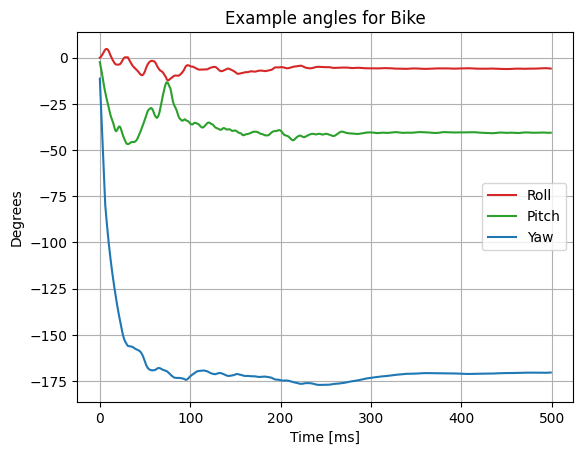

In [7]:
import matplotlib.pyplot as plt

label, eulers = run_over_row(15, euler_angles)

plt.plot(eulers[:, 0], "tab:red", label="Roll")
plt.plot(eulers[:, 1], "tab:green", label="Pitch")
plt.plot(eulers[:, 2], "tab:blue", label="Yaw")
plt.title(f"Example angles for {labels_dict[label]}")
plt.xlabel("Time [ms]")
plt.ylabel("Degrees")
plt.grid()
plt.legend()

plt.show()

In [ ]:
results = run_over_dataset(euler_angles)

Mean of means


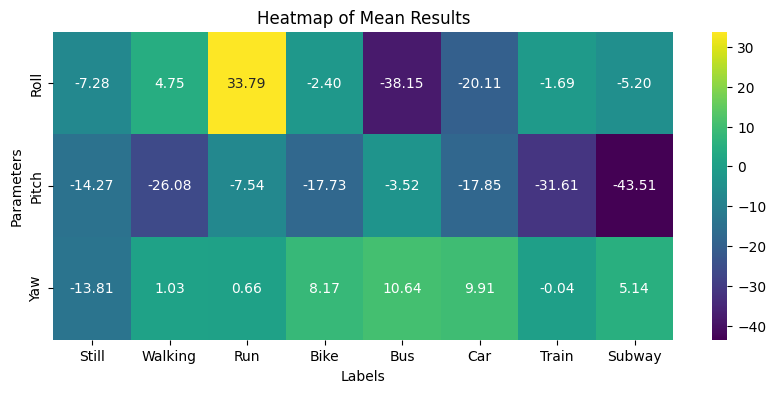

Mean of medians


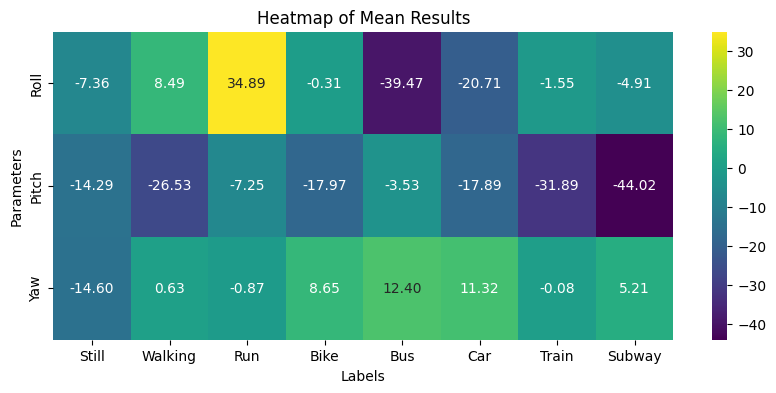

Mean of std


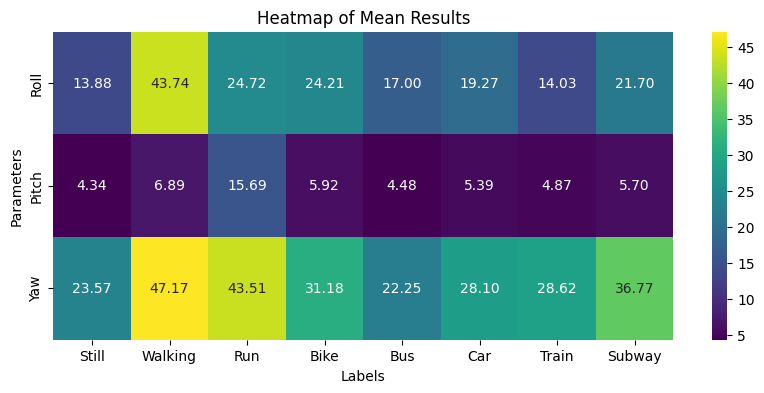

Mean of max


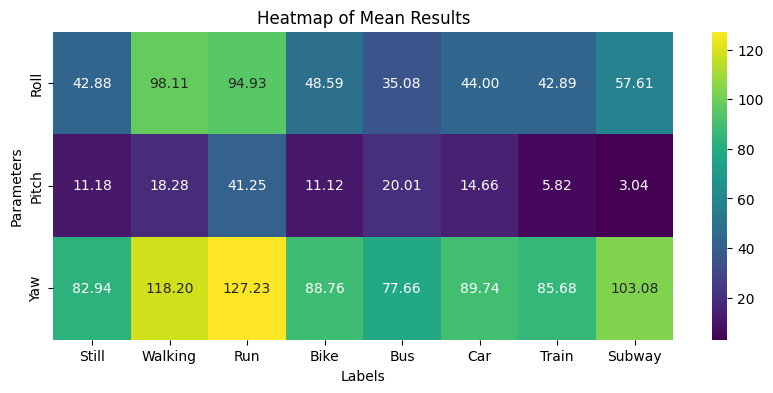

Mean of min


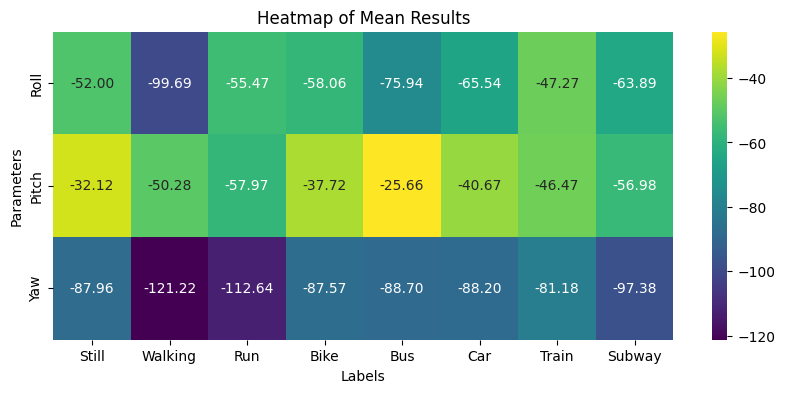

In [133]:
print("Mean of means")
heatmap_of(results, np.mean, ["Roll", "Pitch", "Yaw"])
print("Mean of medians")
heatmap_of(results, np.median, ["Roll", "Pitch", "Yaw"])
print("Mean of std")
heatmap_of(results, np.std, ["Roll", "Pitch", "Yaw"])
print("Mean of max")
heatmap_of(results, np.max, ["Roll", "Pitch", "Yaw"])
print("Mean of min")
heatmap_of(results, np.min, ["Roll", "Pitch", "Yaw"])

#### Reprezentacja kwaternionowa
<img src="https://danceswithcode.net/engineeringnotes/quaternions/images/axis-angle.png" alt="drawing" width="400"/>

In [11]:
import imufusion

def quat_angles(labels, sensors):
    fs = 1/100
    recording_length = 500

    quat = np.empty((recording_length, 4))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((sensors["Acc_x"].reshape(500, 1), sensors["Acc_y"].reshape(500, 1), sensors["Acc_z"].reshape(500, 1)), axis=1)
    gyr = np.concatenate((sensors["Gyr_x"].reshape(500, 1), sensors["Gyr_y"].reshape(500, 1), sensors["Gyr_z"].reshape(500, 1)), axis=1)
    mag = np.concatenate((sensors["Mag_x"].reshape(500, 1), sensors["Mag_y"].reshape(500, 1), sensors["Mag_z"].reshape(500, 1)), axis=1)

    for index in range(recording_length):
        ahrs.update(gyr[index], acc[index], mag[index], fs)
        quat[index] = [ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z, ahrs.quaternion.w]

    label = get_label(labels)

    return label, quat

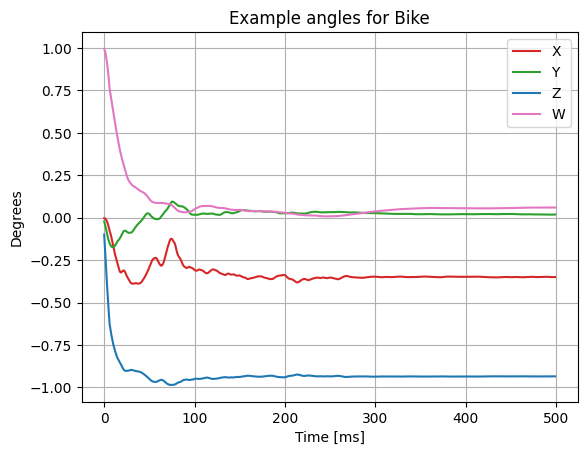

In [12]:
import matplotlib.pyplot as plt

label, quat = run_over_row(15, quat_angles)

plt.plot(quat[:, 0], "tab:red", label="X")
plt.plot(quat[:, 1], "tab:green", label="Y")
plt.plot(quat[:, 2], "tab:blue", label="Z")
plt.plot(quat[:, 3], "tab:pink", label="W")
plt.title(f"Example angles for {labels_dict[label]}")
plt.xlabel("Time [ms]")
plt.ylabel("Degrees")
plt.grid()
plt.legend()

In [47]:
results = run_over_dataset(quat_angles)

Mean of means


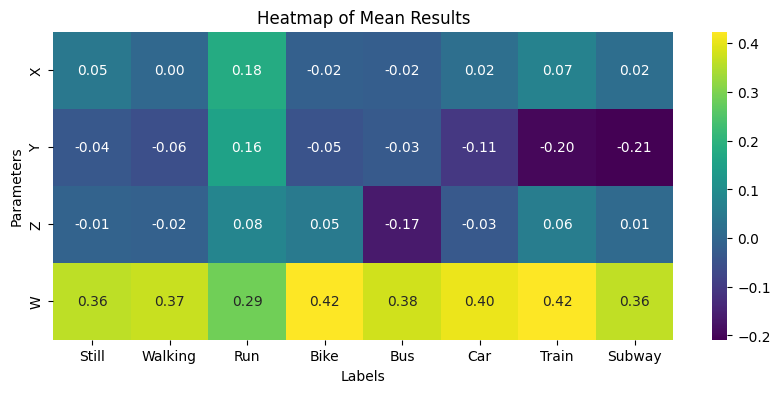

Mean of medians


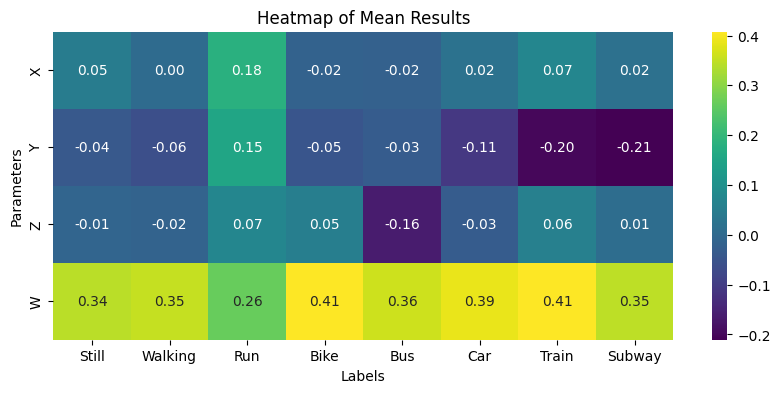

Mean of std


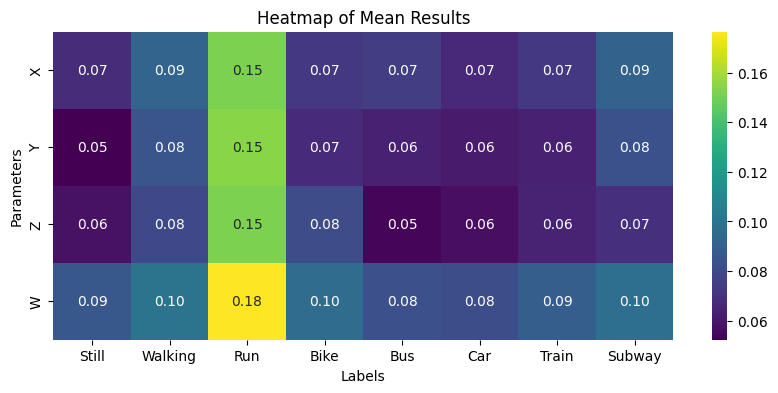

Mean of max


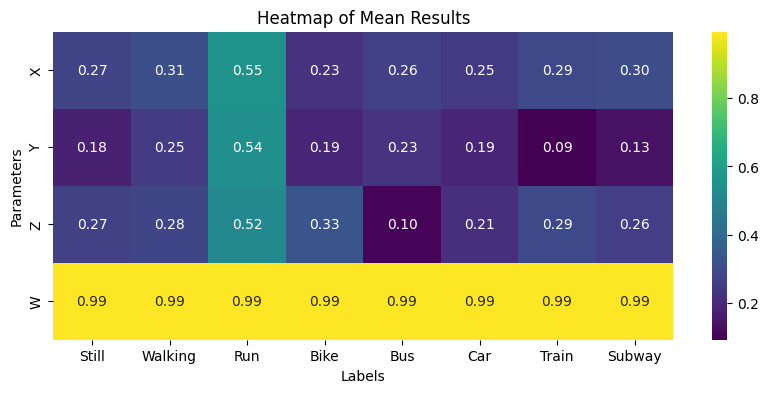

Mean of min


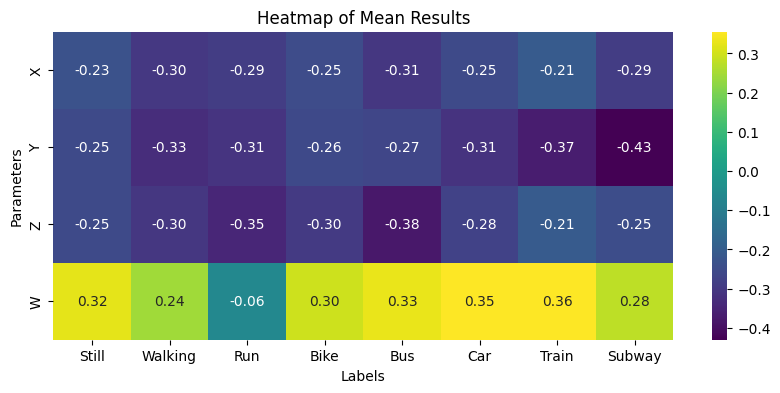

In [49]:
print("Mean of means")
heatmap_of(results, np.mean, ["X", "Y", "Z", "W"])
print("Mean of medians")
heatmap_of(results, np.median, ["X", "Y", "Z", "W"])
print("Mean of std")
heatmap_of(results, np.std, ["X", "Y", "Z", "W"])
print("Mean of max")
heatmap_of(results, np.max, ["X", "Y", "Z", "W"])
print("Mean of min")
heatmap_of(results, np.min, ["X", "Y", "Z", "W"])

#### Rozdzielenie czynnika grawitacyjnego od przyspieszenia linowego

0, 1, 2 - nieprzefiltrowane
3, 4, 5 - usunięte g

In [19]:
import imufusion
from scipy.spatial.transform import Rotation as R
import scipy


def acc_g_separation(labels, sensors):
    fs = 1/100
    recording_length = 500

    lin_acc = np.empty((recording_length, 6))
    ahrs = imufusion.Ahrs()

    acc = np.concatenate((sensors["Acc_x"].reshape(500, 1), sensors["Acc_y"].reshape(500, 1), sensors["Acc_z"].reshape(500, 1)), axis=1)
    gyr = np.concatenate((sensors["Gyr_x"].reshape(500, 1), sensors["Gyr_y"].reshape(500, 1), sensors["Gyr_z"].reshape(500, 1)), axis=1)
    mag = np.concatenate((sensors["Mag_x"].reshape(500, 1), sensors["Mag_y"].reshape(500, 1), sensors["Mag_z"].reshape(500, 1)), axis=1)

    last_rot = R.from_quat([0,0,0,1])

    for index in range(recording_length):
        ahrs.update(gyr[index], acc[index], mag[index], fs)

        q = [ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z, ahrs.quaternion.w]
        try:
            rotation = R.from_quat(q)
        except:
            print("Wrong quat", q, "assuming previous rotation", last_rot)
            rotation = last_rot
        gravity = rotation.inv().apply([0, 0, 9.81])
        linear_acc = acc[index] - gravity

        lin_acc[index][0:3] = acc[index]
        lin_acc[index][3:6] = linear_acc

        last_rot = rotation

    label = get_label(labels)

    return label, lin_acc

6


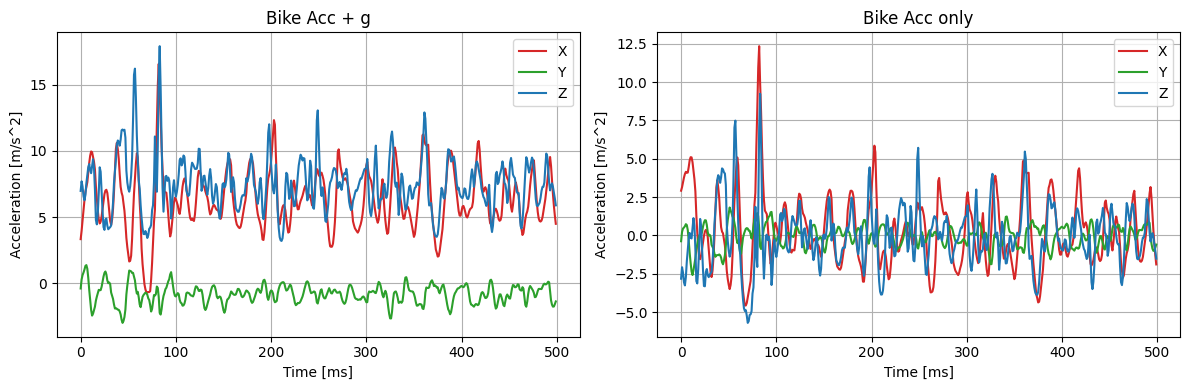

In [ ]:
import matplotlib.pyplot as plt

label, accs = run_over_row(15, acc_g_separation)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(accs[:, 0], "tab:red", label="X")
ax1.plot(accs[:, 1], "tab:green", label="Y")
ax1.plot(accs[:, 2], "tab:blue", label="Z")
ax1.set_title(f"{labels_dict[label]} Acc + g")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Acceleration [m/s^2]")
ax1.grid()
ax1.legend()

ax2.plot(accs[:, 3], "tab:red", label="X")
ax2.plot(accs[:, 4], "tab:green", label="Y")
ax2.plot(accs[:, 5], "tab:blue", label="Z")
ax2.set_title(f"{labels_dict[label]} Acc only")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Acceleration [m/s^2]")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show() 

o s t r o ż n i e - liczyło się u mnie ok. 20 minut

In [117]:
resultsAccs = run_over_dataset(acc_g_separation)

Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spatial.transform._rotation.Rotation object at 0x000002033C2EF1E0>
Wrong quat [nan, nan, nan, nan] assuming previous rotation <scipy.spa

Mean of means


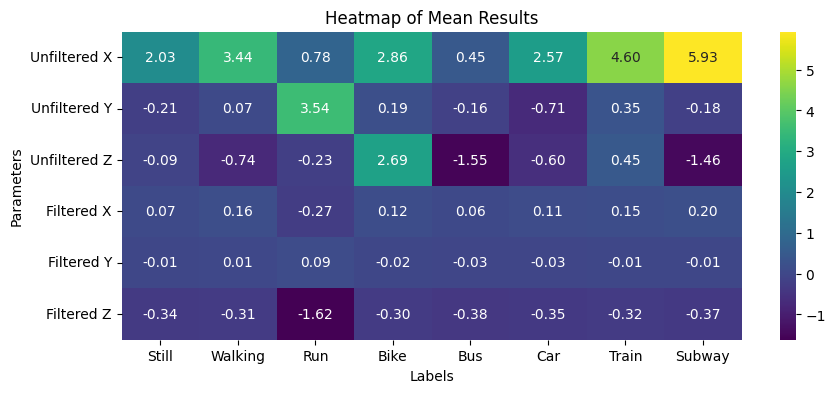

Mean of medians


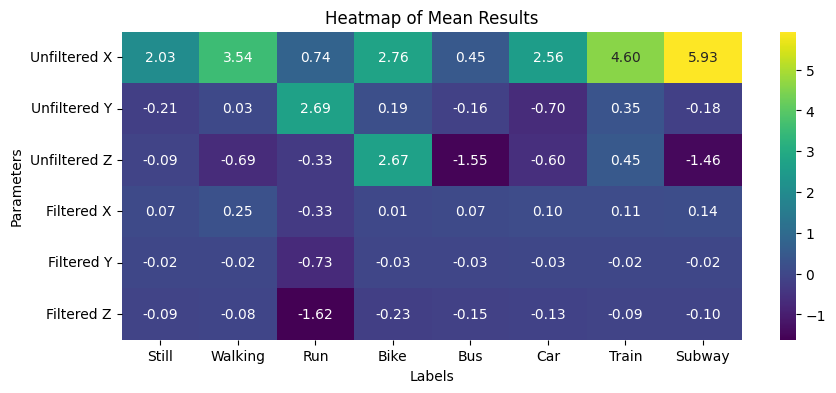

Mean of std


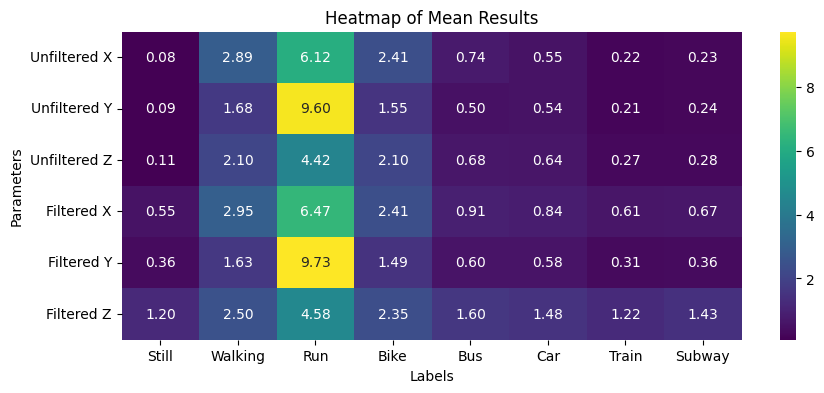

Mean of max


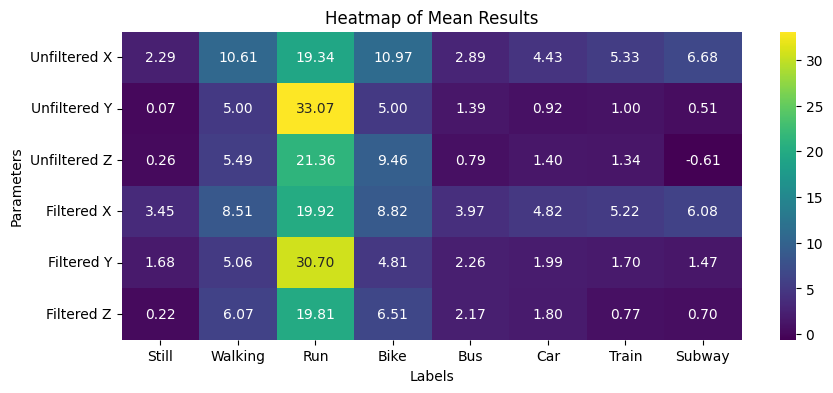

Mean of min


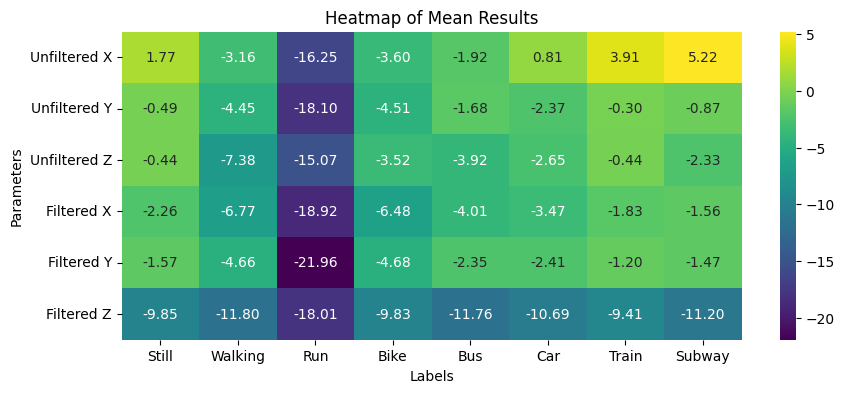

In [137]:
print("Mean of means")
heatmap_of(resultsAccs, np.mean, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of medians")
heatmap_of(resultsAccs, np.median, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of std")
heatmap_of(resultsAccs, np.std, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of max")
heatmap_of(resultsAccs, np.max, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])
print("Mean of min")
heatmap_of(resultsAccs, np.min, ["Unfiltered X", "Unfiltered Y", "Unfiltered Z", "Filtered X", "Filtered Y", "Filtered Z"])